In [1]:
# Autoreaload
%load_ext autoreload
%autoreload 2

In [215]:
# Imports
import pandas as pd
import re
import numpy as np
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from IPython.display import Markdown as md, display
from helper import add_top_column

In [216]:
def recover_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'category':
            df[col] = df[col].astype(df[col].cat.categories.to_numpy().dtype)
    return df


In [531]:
tcells = sc.read('../data_out/matrix_merged_cell_metadata.h5ad')

In [533]:
# Todas las células mismo count the gene expr
sc.pp.normalize_total(tcells, target_sum=1e4)
tcells.X.sum(axis=1)

matrix([[10000.009],
        [ 9999.878],
        [10000.03 ],
        ...,
        [10000.088],
        [10000.125],
        [ 9999.95 ]], dtype=float32)

In [534]:
total_cels_per_gene =  np.array((tcells.X > 0).sum(axis=0))[0]
total_cels_per_gene

array([   0,    0,    0, ..., 3543, 8856,  875])

In [535]:
indexes = total_cels_per_gene.argsort()[::-1]
df_house_keep = tcells.var.iloc[indexes]
df_house_keep['count'] = total_cels_per_gene[indexes]
df_house_keep.head(30)

/tmp/ipykernel_2105692/1386573910.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_house_keep['count'] = total_cels_per_gene[indexes]


,gene_ids,feature_types,count
MT-CO1,ENSG00000198804,Gene Expression,103725
MT-ATP6,ENSG00000198899,Gene Expression,103720
MT-CO2,ENSG00000198712,Gene Expression,103718
MT-ND4,ENSG00000198886,Gene Expression,103716
MT-CO3,ENSG00000198938,Gene Expression,103708
MT-ND1,ENSG00000198888,Gene Expression,103643
MT-CYB,ENSG00000198727,Gene Expression,103599
MALAT1,ENSG00000251562,Gene Expression,103459
MT-ND3,ENSG00000198840,Gene Expression,103443
MT-ND5,ENSG00000198786,Gene Expression,103306


In [536]:
housekeeping_gene = 'ACTB'
# housekeeping_gene = 'GAPDH'
# housekeeping_gene = 'RPL13A'
assert housekeeping_gene in tcells.var.index

hk_expression = tcells[:, housekeeping_gene].X
hk_expression

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 100880 stored elements and shape (103805, 1)>

In [537]:
gene_expression = tcells[:, 'TNF'].X
tcells.obs['tnf_fold_change'] = np.divide(gene_expression.todense(), hk_expression.todense() + 1)

In [538]:
tcells

AnnData object with n_obs × n_vars = 103805 × 36755
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'tnf_fold_change'
    var: 'gene_ids', 'feature_types'

In [539]:
import numpy as np
tcells.obs['TNF'] = np.array(tcells[:, tcells.var.index == 'TNF'].X.todense())
tcells.obs['log_TNF'] = np.log1p(tcells.obs['TNF'])

In [540]:
df_obs = tcells.obs[tcells.obs['condition'].isin(['Nostim', 'Stim'])]
df_obs['gene'] = df_obs['gene'].astype(df_obs['gene'].cat.categories.to_numpy().dtype) 

df_obs['gene']

/tmp/ipykernel_2105692/3487420883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_obs['gene'] = df_obs['gene'].astype(df_obs['gene'].cat.categories.to_numpy().dtype)


AAACCCACAACAAGAT-1        PLCG2
AAACCCACAACGGCTC-1        HELZ2
AAACCCACACCCTGTT-1       OTUD7B
AAACCCACACTATGTG-1        CD247
AAACCCAGTACAGGTG-1        PRKD2
                        ...    
TTTGTTGCACAGCCAC-8    TNFRSF12A
TTTGTTGCACTATGTG-8         LHX6
TTTGTTGCACTCAGAT-8        TBX21
TTTGTTGCAGTCAGTT-8       TRIM21
TTTGTTGGTGAGTGAC-8        IL2RB
Name: gene, Length: 60657, dtype: object

In [541]:
def get_sorted_genes(y, min_number_of_cells=200, top_n=40):
    df_TNF_stim = df_obs[df_obs['condition'] == 'Stim'].sort_values('TNF').dropna(subset=['guide_id']).groupby('gene').agg(
        TNF_stim_mean=('TNF', 'mean'), TNF_stim_std=('TNF', 'std'), TNF_stim_sum=('TNF', 'sum'), TNF_stim_max=('TNF', 'max'), TNF_stim_count=('TNF', 'count'),
        tnf_fold_change_stim_mean=('tnf_fold_change', 'mean'),
        guide_id_stim=('guide_id', lambda x: pd.Series(list(x)).value_counts().sort_index().to_dict()),
        well_stim=('well', lambda x: pd.Series(x).value_counts().sort_index().to_dict())
    ).sort_values(f'{y}_stim_mean', ascending=False).reset_index()
    top_n_genes = list(df_TNF_stim[df_TNF_stim['TNF_stim_count'] >= min_number_of_cells]['gene'].head(top_n)) + ['NO-TARGET']
    
    return list(df_TNF_stim[df_TNF_stim['gene'].isin(top_n_genes)]['gene'])


In [542]:
top_n_genes = get_sorted_genes('tnf_fold_change')
df_obs_top_n = df_obs[
    df_obs['gene'].isin(top_n_genes)
].copy()
df_obs_top_n

,condition,crispr,guide_id,gene,well,tnf_fold_change,TNF,log_TNF
AAACCCACAACAAGAT-1,Nostim,perturbed,PLCG2-2,PLCG2,1,0.000000,0.000000,0.000000
AAACCCACACCCTGTT-1,Nostim,perturbed,OTUD7B-1,OTUD7B,1,0.000000,0.000000,0.000000
AAACCCAGTATGAGAT-1,Nostim,perturbed,IL2RB-2,IL2RB,1,0.000000,0.000000,0.000000
AAACCCATCGGCATTA-1,Nostim,perturbed,CNR2-1,CNR2,1,0.000000,0.000000,0.000000
AAACCCATCTACCTTA-1,Nostim,perturbed,PLCG2-2,PLCG2,1,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
TTTGTTGAGGTATTGA-8,Stim,perturbed,PIK3AP1-1,PIK3AP1,8,0.000000,0.000000,0.000000
TTTGTTGCACTATGTG-8,Stim,perturbed,LHX6-2,LHX6,8,0.000000,0.000000,0.000000
TTTGTTGCACTCAGAT-8,Stim,perturbed,TBX21-2,TBX21,8,0.000000,0.000000,0.000000
TTTGTTGCAGTCAGTT-8,Stim,perturbed,TRIM21-2,TRIM21,8,0.057841,3.461406,1.495464


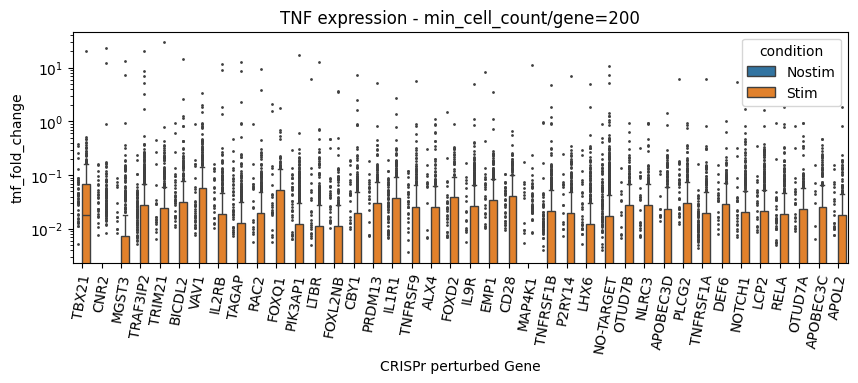

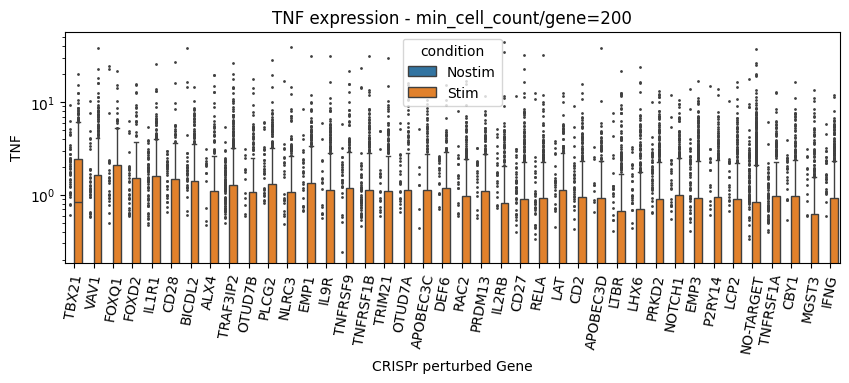

In [544]:
def plot_tnf_expression(y, min_number_of_cells=200, top_n=40):
    top_n_genes = get_sorted_genes(y, min_number_of_cells=min_number_of_cells, top_n=top_n)
    df_obs_top_n = df_obs[
        df_obs['gene'].isin(top_n_genes)
    ].copy()
    plt.figure(figsize=(10,3))
    plt.title(f'TNF expression - min_cell_count/gene={min_number_of_cells}')
    flierprops = dict(markerfacecolor='0.75', markersize=1,
                linestyle='none')
    sns.boxplot(
        data=df_obs_top_n, x="gene", y=y, hue="condition",
        order=top_n_genes,
        flierprops=flierprops
    )
    plt.yscale('log')
    plt.xticks(rotation=80);
    plt.xlabel('CRISPr perturbed Gene')
    plt.ylabel(y)
    # plt.ylim(1e-10, 1e10)
plot_tnf_expression('tnf_fold_change')
plot_tnf_expression('TNF')

In [393]:
df_obs[df_obs['gene'].isin(top_n_genes)][['gene', 'TNF', 'condition']].groupby(['gene', 'condition']).sum().reset_index('condition')

/tmp/ipykernel_2105692/1772472302.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_obs[df_obs['gene'].isin(top_n_genes)][['gene', 'TNF', 'condition']].groupby(['gene', 'condition']).sum().reset_index('condition')


,condition,TNF
gene,,
ABCB10,Nostim,13.005602
ABCB10,Stim,147.753876
ALX4,Nostim,23.061636
ALX4,Stim,291.567474
APOBEC3C,Nostim,12.519032
...,...,...
TRIM21,Stim,439.924622
VAV1,Nostim,69.512627
VAV1,Stim,672.528381


In [394]:
res = df_obs_top_n[['gene', 'TNF', 'condition']].groupby(['condition', 'gene']).mean()
pd.concat([res.loc['Nostim'].rename(columns={'TNF': 'TNF_nostim'}), res.loc['Stim'].rename(columns={'TNF': 'TNF_stim'})], axis=1).sort_values('TNF_stim', ascending=False)

/tmp/ipykernel_2105692/1172351754.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res = df_obs_top_n[['gene', 'TNF', 'condition']].groupby(['condition', 'gene']).mean()


,TNF_nostim,TNF_stim
gene,,
TBX21,0.295574,1.672549
VAV1,0.151774,1.497836
FOXQ1,0.296011,1.406625
FOXD2,0.159572,1.288952
IL1R1,0.232514,1.199083
...,...,...
GATA3,0.027240,0.348488
FOSB,0.062722,0.317892
MUC1,0.051698,0.282571


In [43]:
df_obs_top_10.value_counts('gene')

gene
TRAF3IP2    1564
TNFRSF1B    1344
VAV1         907
IL1R1        871
CD28         815
            ... 
IL2RG          0
IL9R           0
INPPL1         0
AKAP12         0
WT1            0
Name: count, Length: 74, dtype: int64

AAACGAACAAGTTTGC-1    TRAF3IP2
AAACGAAGTCACTTAG-1        CD28
AAACGCTAGTGGCGAT-1    TNFRSF1B
AAAGGGCCAGGGTCTC-1        CD28
AAATGGAAGCGATGAC-1       IL1R1
                        ...   
TTTGACTTCTGATGGT-8       IL1R1
TTTGGAGCAGAGGCTA-8       IL1R1
TTTGGAGGTACTGAGG-8       FOXQ1
TTTGGTTTCTAGCCTC-8        VAV1
TTTGTTGCACTCAGAT-8       TBX21
Name: gene, Length: 7580, dtype: category
Categories (10, object): ['CD28', 'EOMES', 'FOXD2', 'FOXQ1', ..., 'TBX21', 'TNFRSF1B', 'TRAF3IP2', 'VAV1']